- 리눅스 마스터 : 리눅스 자격증
    - 순수 리눅스는 GUI가 없음

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

work_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(work_path)

from hossam.util import *
from hossam.plot import *
from hossam.timeserise import *
from yjk_module.preprocessing import *
from yjk_module.ml_module import *

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import GridSearchCV
from concurrent import futures

In [2]:
origin = pd.read_excel("./data/air_passengers.xlsx")

In [3]:
df1 = origin.rename(columns = {"Month" : "ds", "Passengers" : "y"})

In [4]:
df1.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


- prophet의 하이퍼파라미터
    - growth : 추정치의 상한선/하한선 설정
        - linear : 제한 없음
        - logistic : 제한 설정, cap과 floor로 상한/하한을 설정함
        - 상한/하한은 억제력으로서 작용하며 완전한 제한이 아니라서 뚫을 가능성이 있으며 충분한 도메인 지식을 기반으로 설정해야 함

In [5]:
max_value = 500
min_value = 80

In [6]:
df1_2 = df1.copy()
df1_2['cap'] = max_value
df1_2['floor'] = min_value

In [7]:
train, test = my_timeseries_split(df1_2)

16:51:24 - cmdstanpy - INFO - Chain [1] start processing
16:51:24 - cmdstanpy - INFO - Chain [1] done processing


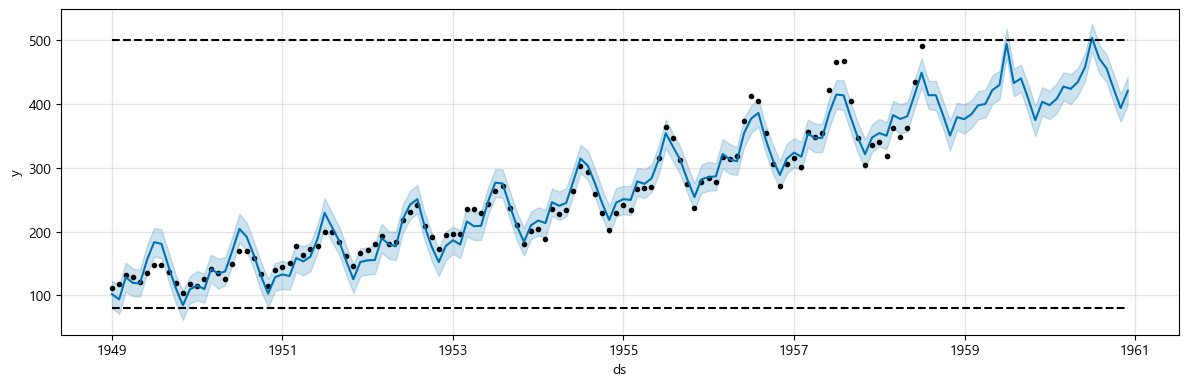

In [8]:
m = Prophet(growth = 'logistic')
m.fit(train)

future = m.make_future_dataframe(periods = len(test), freq = 'M')
future['cap'] = max_value
future['floor'] = min_value

forecast = m.predict(future)

fig = m.plot(forecast, figsize = (12, 4))
fig.set_dpi(100)
ax = fig.gca()
plt.show()

- Trend 관련 파라미터
    - changepoints : 트렌드 변화시점을 명시하는 리스트, 트렌드 변화시점을 확실히 아는게 아니면 쓰지는 않음
    - changepoint_prior_scale : 트렌드의 유연성, 높을수록 추세에 더 유연하게 반영
    - n_changepoints : changepoint의 개수, 숫자는 넉넉하게 높게 설정 (기본 25)
    - changepoint_range : changepoint 설정 가능 범위 (기본 0.8)

16:51:25 - cmdstanpy - INFO - Chain [1] start processing
16:51:25 - cmdstanpy - INFO - Chain [1] done processing


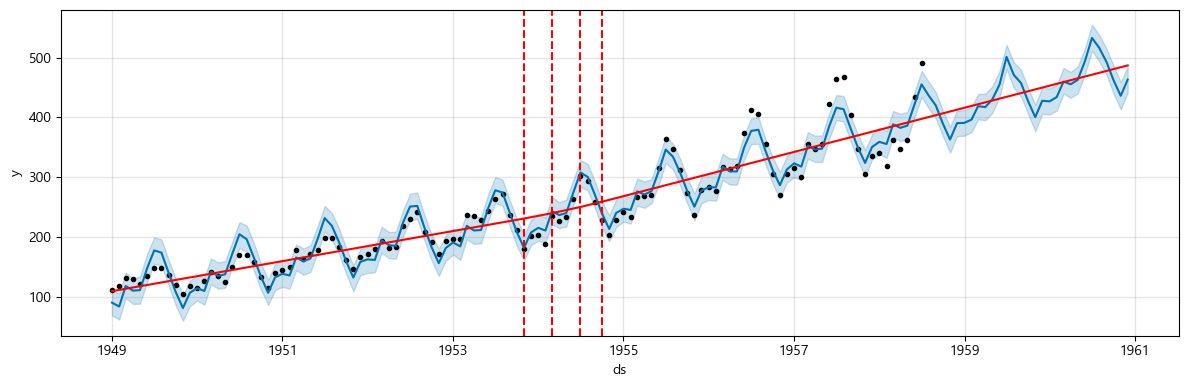

In [9]:
train, test = my_timeseries_split(df1.copy())

m = Prophet()
m.fit(train)

future = m.make_future_dataframe(periods = len(test), freq = "M")
forecast = m.predict(future)

fig = m.plot(forecast, figsize = (12, 4))
add_changepoints_to_plot(fig.gca(), m, forecast)

fig.set_dpi(100)
ax = fig.gca()
plt.show()

- change_prior_scale은 너무 높거나 낮으면 과적합이 발생할 수 있으므로 적정한 값으로 조절

16:51:25 - cmdstanpy - INFO - Chain [1] start processing
16:51:25 - cmdstanpy - INFO - Chain [1] done processing


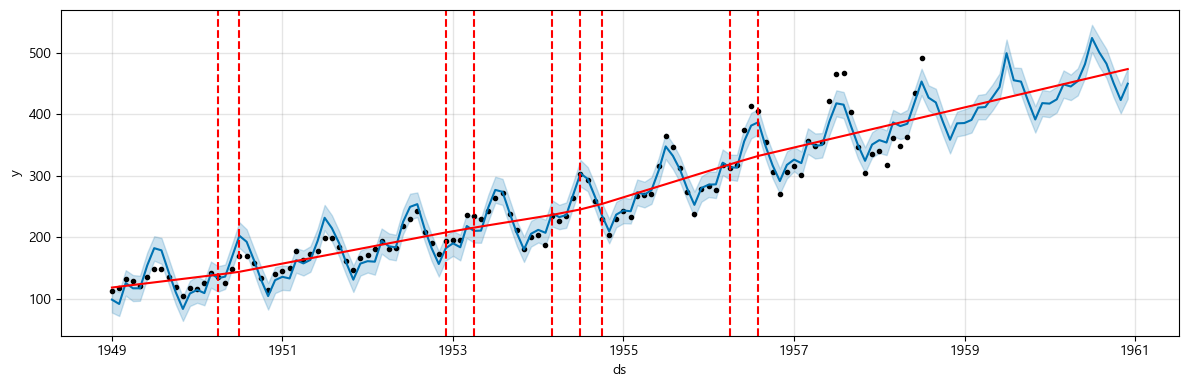

In [10]:
m = Prophet(changepoint_prior_scale = 0.2)
m.fit(train)

future = m.make_future_dataframe(periods = len(test), freq = 'M')
forecast = m.predict(future)

fig = m.plot(forecast, figsize = (12, 4))
add_changepoints_to_plot(fig.gca(), m, forecast)

fig.set_dpi(100)
ax = fig.gca()
plt.show()

16:51:25 - cmdstanpy - INFO - Chain [1] start processing
16:51:25 - cmdstanpy - INFO - Chain [1] done processing


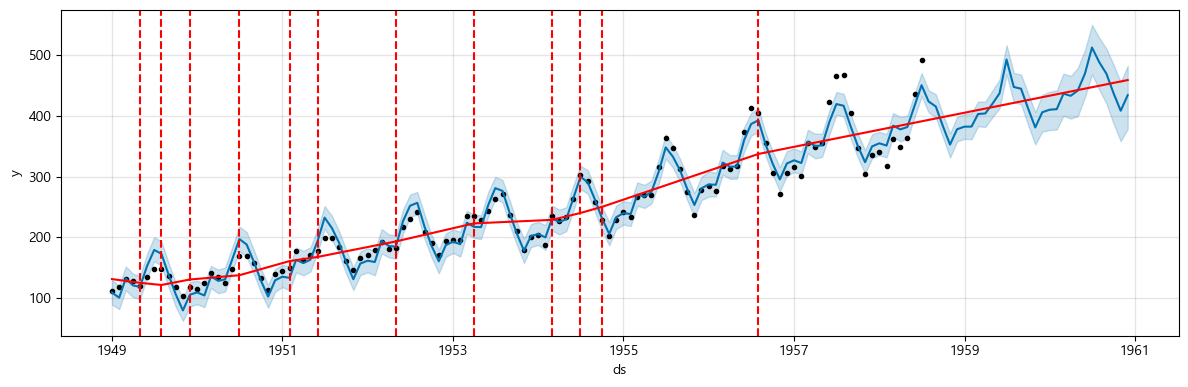

In [11]:
m = Prophet(changepoint_prior_scale = 0.9)
m.fit(train)

future = m.make_future_dataframe(periods = len(test), freq = 'M')
forecast = m.predict(future)

fig = m.plot(forecast, figsize = (12, 4))
add_changepoints_to_plot(fig.gca(), m, forecast)

fig.set_dpi(100)
ax = fig.gca()
plt.show()

- 계절성 조절
    - yearly / weekly / daily _seasonality : 각 단위별로 계절성 활성화
        - bool 단위로 설정하면 자동으로 구간을 찾지만 숫자로 설정하면 해당 단위로 계절성을 찾음, bool 권장
        - 별도 설정이 없으며 년단위만 찾음
    - seasonality_prior_scale : 계절성 반영 강도 [0.01 ~ 10] 사이
    - seasonality_mode : additive (기본값, 진폭이 일정) multiplicative (진폭이 변화)

16:51:26 - cmdstanpy - INFO - Chain [1] start processing
16:51:26 - cmdstanpy - INFO - Chain [1] done processing


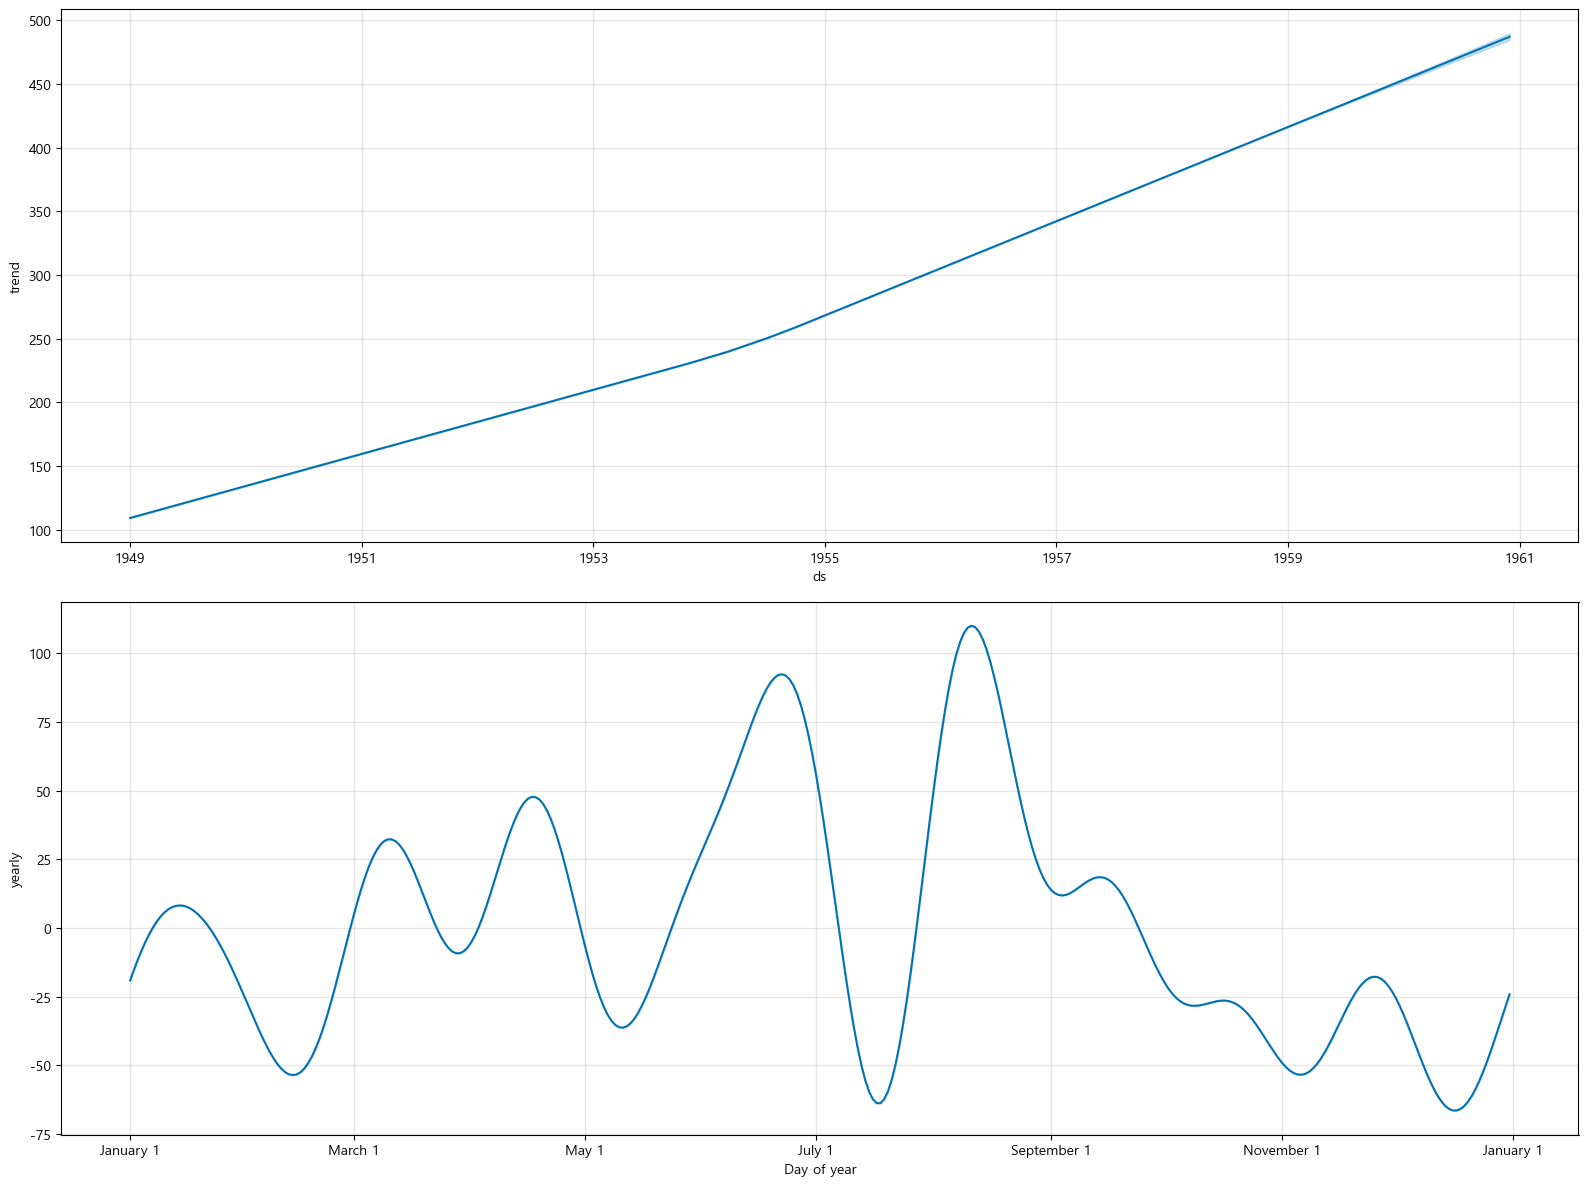

In [12]:
m = Prophet()
m.fit(train)

future = m.make_future_dataframe(periods = len(test), freq = "M")
forecast = m.predict(future)

fig = m.plot_components(forecast, figsize = (16, 12))
fig.set_dpi(100)
ax = fig.gca()
plt.show()

16:51:26 - cmdstanpy - INFO - Chain [1] start processing
16:51:26 - cmdstanpy - INFO - Chain [1] done processing


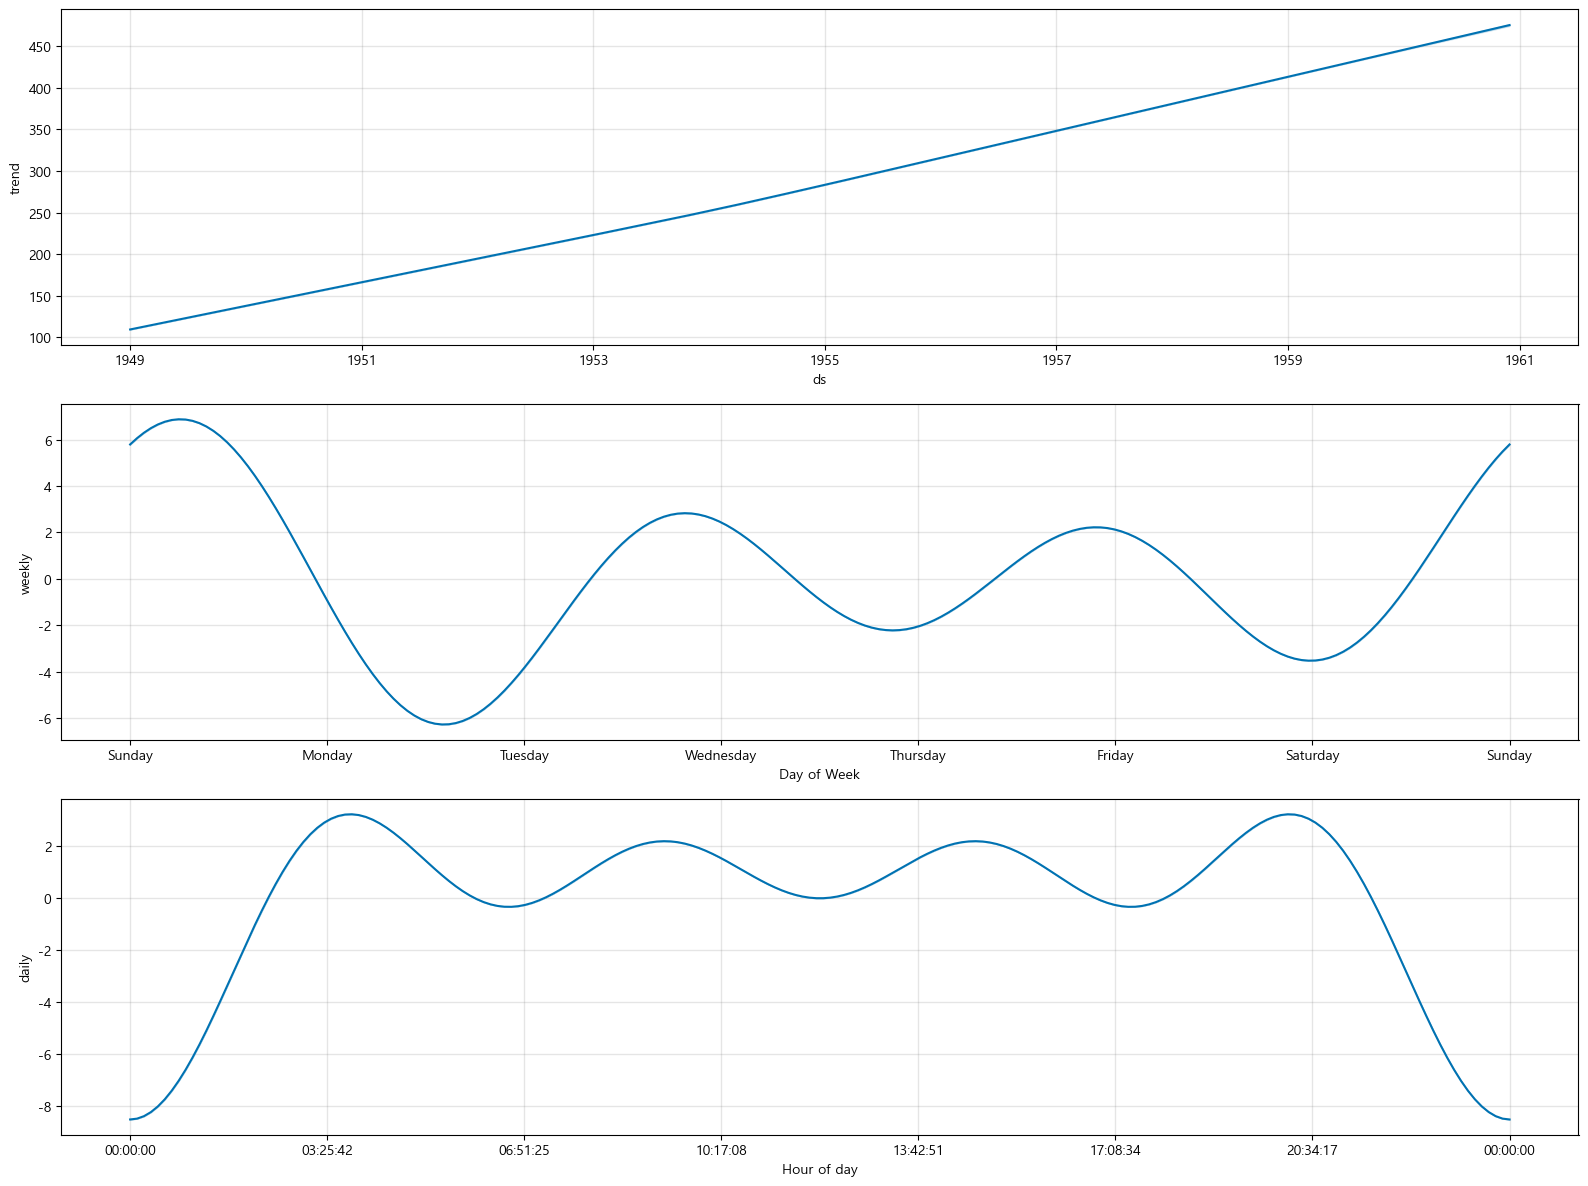

In [13]:
m = Prophet(
    yearly_seasonality = False,
    weekly_seasonality = True,
    daily_seasonality = True,
    seasonality_prior_scale = 1
)
m.fit(train)

future = m.make_future_dataframe(periods = len(test), freq = 'M')
forecast = m.predict(future)

fig = m.plot_components(forecast, figsize = (16, 12))
fig.set_dpi(100)
ax = fig.gca()
plt.show()

- 계절성 수동 추가 : fit 전에 add_seasonality로 직접 계절성을 추가할 수 있음
    - period : 계절성의 범위, 단위는 일
    - furier_order : 푸리에 차수, 기본적으로 주 단위는 3에 년 단위는 10을 사용, 월 단위는 그 중간의 적합한 값을 추정해서 입력함 (5)
- 조건부 계절성 추가도 가능함
    - https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

16:51:26 - cmdstanpy - INFO - Chain [1] start processing
16:51:27 - cmdstanpy - INFO - Chain [1] done processing


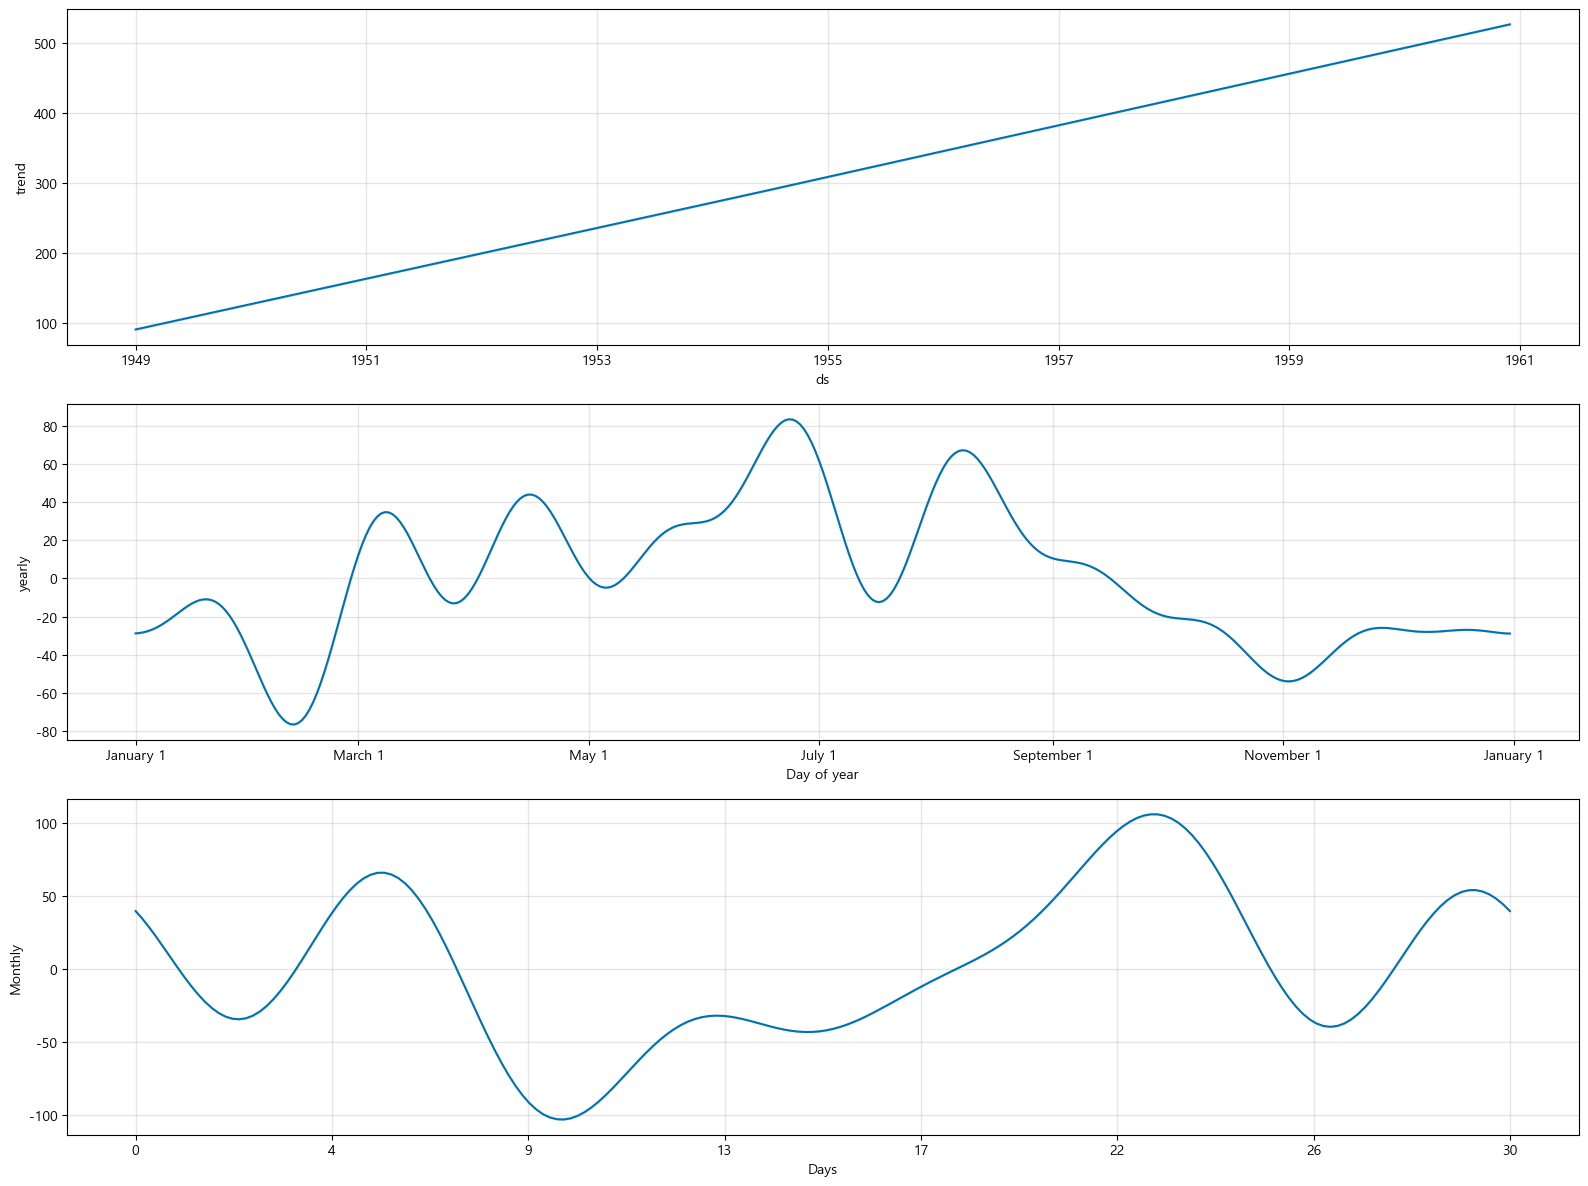

In [14]:
m = Prophet()

m.add_seasonality(name = 'Monthly', period = 30.5, fourier_order = 5)

m.fit(train)

future = m.make_future_dataframe(periods = len(test), freq = 'M')
forecast = m.predict(future)

fig = m.plot_components(forecast, figsize = (16, 12))
fig.set_dpi(100)
ax = fig.gca()
plt.show()

- 공휴일 설정
    - 공휴일 데이터 프레임 직접 설정
        - 객체 생성시 holiday 관련 파라미터를 설정
    - 날짜 기간은 pandas의 date_range로 생성

In [15]:
pd.date_range('2017-05-05', '2017-06-03', freq = 'D')

DatetimeIndex(['2017-05-05', '2017-05-06', '2017-05-07', '2017-05-08',
               '2017-05-09', '2017-05-10', '2017-05-11', '2017-05-12',
               '2017-05-13', '2017-05-14', '2017-05-15', '2017-05-16',
               '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20',
               '2017-05-21', '2017-05-22', '2017-05-23', '2017-05-24',
               '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28',
               '2017-05-29', '2017-05-30', '2017-05-31', '2017-06-01',
               '2017-06-02', '2017-06-03'],
              dtype='datetime64[ns]', freq='D')

In [16]:
holidays = pd.DataFrame({
    'holiday' : 'holiday',
    'ds' : pd.concat([
        pd.Series(pd.date_range('1949-05-05', '1949-06-03', freq = 'D')),
        pd.Series(pd.date_range('1950-05-05', '1950-06-03', freq = 'D')),
        pd.Series(pd.date_range('1951-05-05', '1951-06-03', freq = 'D')),
        pd.Series(pd.date_range('1952-05-05', '1952-06-03', freq = 'D')),
        pd.Series(pd.date_range('1953-05-05', '1953-06-03', freq = 'D')),
        pd.Series(pd.date_range('1954-05-05', '1954-06-03', freq = 'D')),
        pd.Series(pd.date_range('1955-05-05', '1955-06-03', freq = 'D')),
        pd.Series(pd.date_range('1956-05-05', '1956-06-03', freq = 'D')),
        pd.Series(pd.date_range('1957-05-05', '1957-06-03', freq = 'D')),
        pd.Series(pd.date_range('1958-05-05', '1958-06-03', freq = 'D')),
        pd.Series(pd.date_range('1959-05-05', '1959-06-03', freq = 'D')),
        pd.Series(pd.date_range('1960-05-05', '1960-06-03', freq = 'D'))
    ])
})

holidays.head()

,holiday,ds
0,holiday,1949-05-05
1,holiday,1949-05-06
2,holiday,1949-05-07
3,holiday,1949-05-08
4,holiday,1949-05-09


16:51:27 - cmdstanpy - INFO - Chain [1] start processing
16:51:27 - cmdstanpy - INFO - Chain [1] done processing


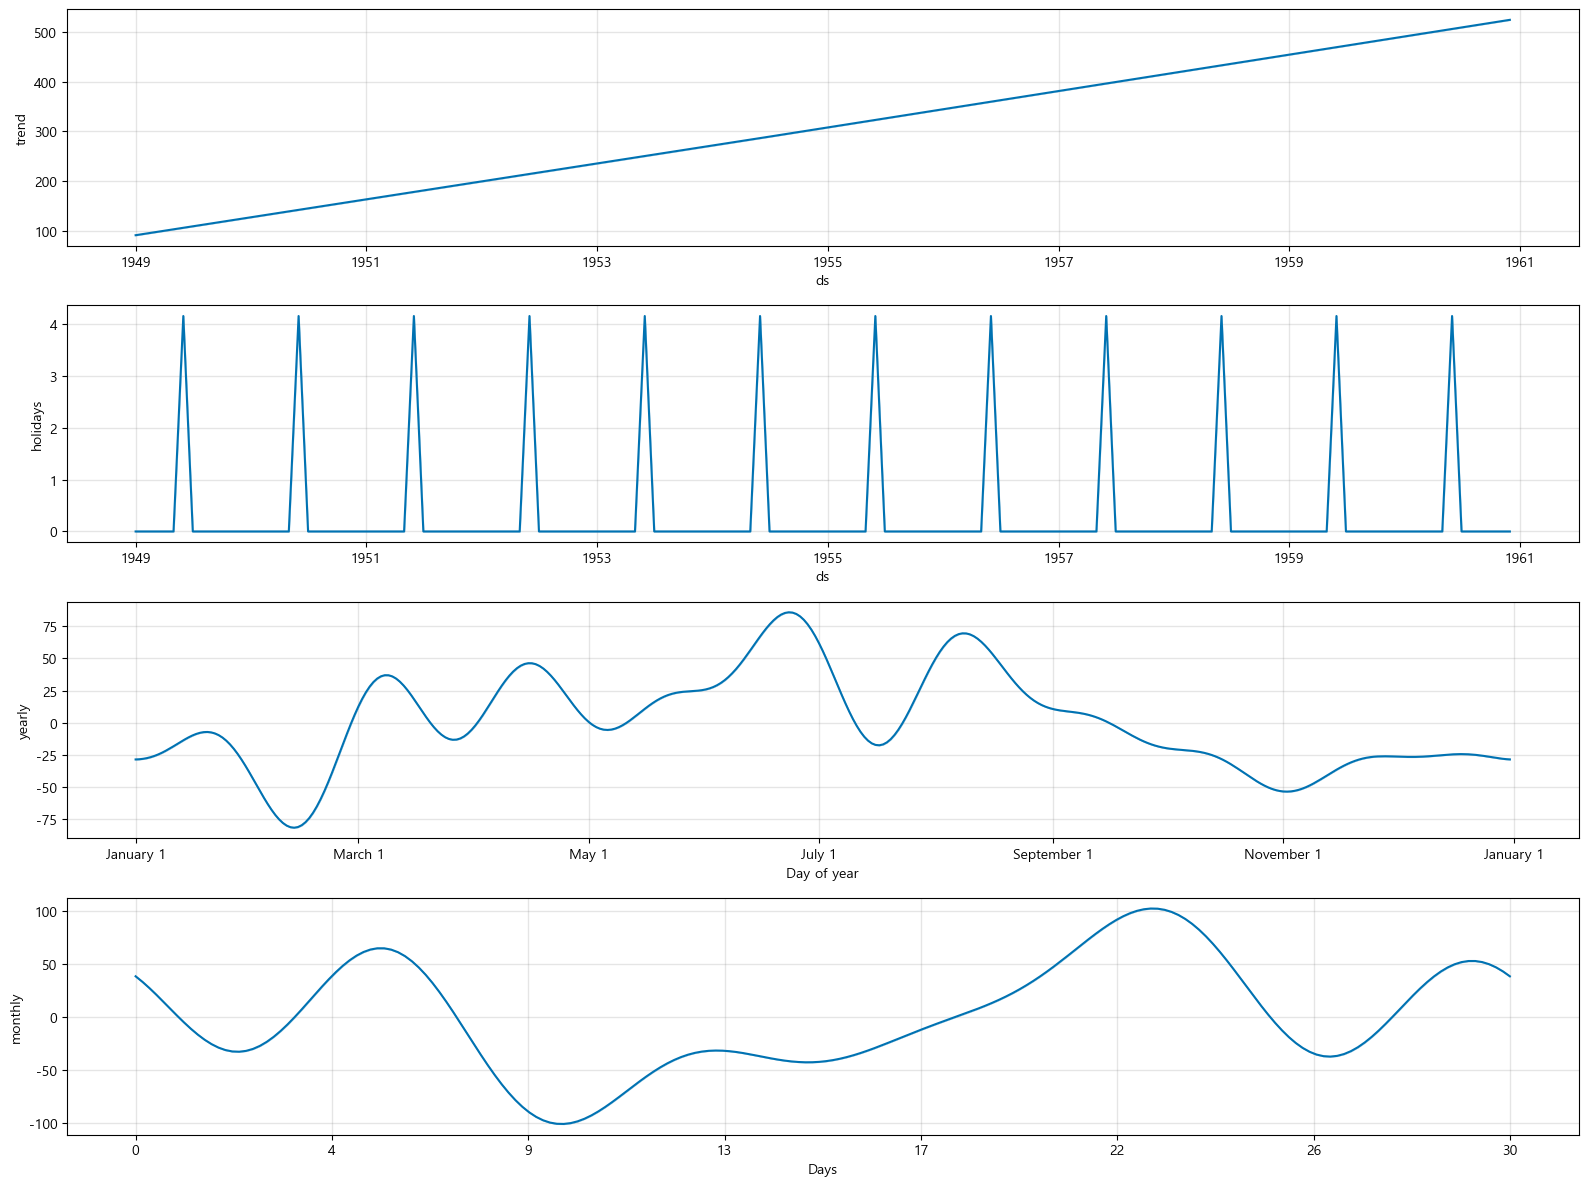

In [17]:
m = Prophet(
    holidays=holidays,
    holidays_prior_scale = 15
)

m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)

fig = m.plot_components(forecast, figsize=(16, 12))
fig.set_dpi(100)
ax = fig.gca()
plt.show()

- API를 통한 공휴일 데이터 활용
    - 대한민국은 KR
    - 모델 객체에 add_country_holiday의 파라미터 country_name을 지정하여 공휴일 추가
        - m.train_holiday_name로 공휴일 목록 확인 가능
            - 한국의 공휴일은 음력을 고려하지 않고 공휴일이 아닌 기념일들이 들어간것이 많아 정확하지 않음

16:51:28 - cmdstanpy - INFO - Chain [1] start processing
16:51:28 - cmdstanpy - INFO - Chain [1] done processing


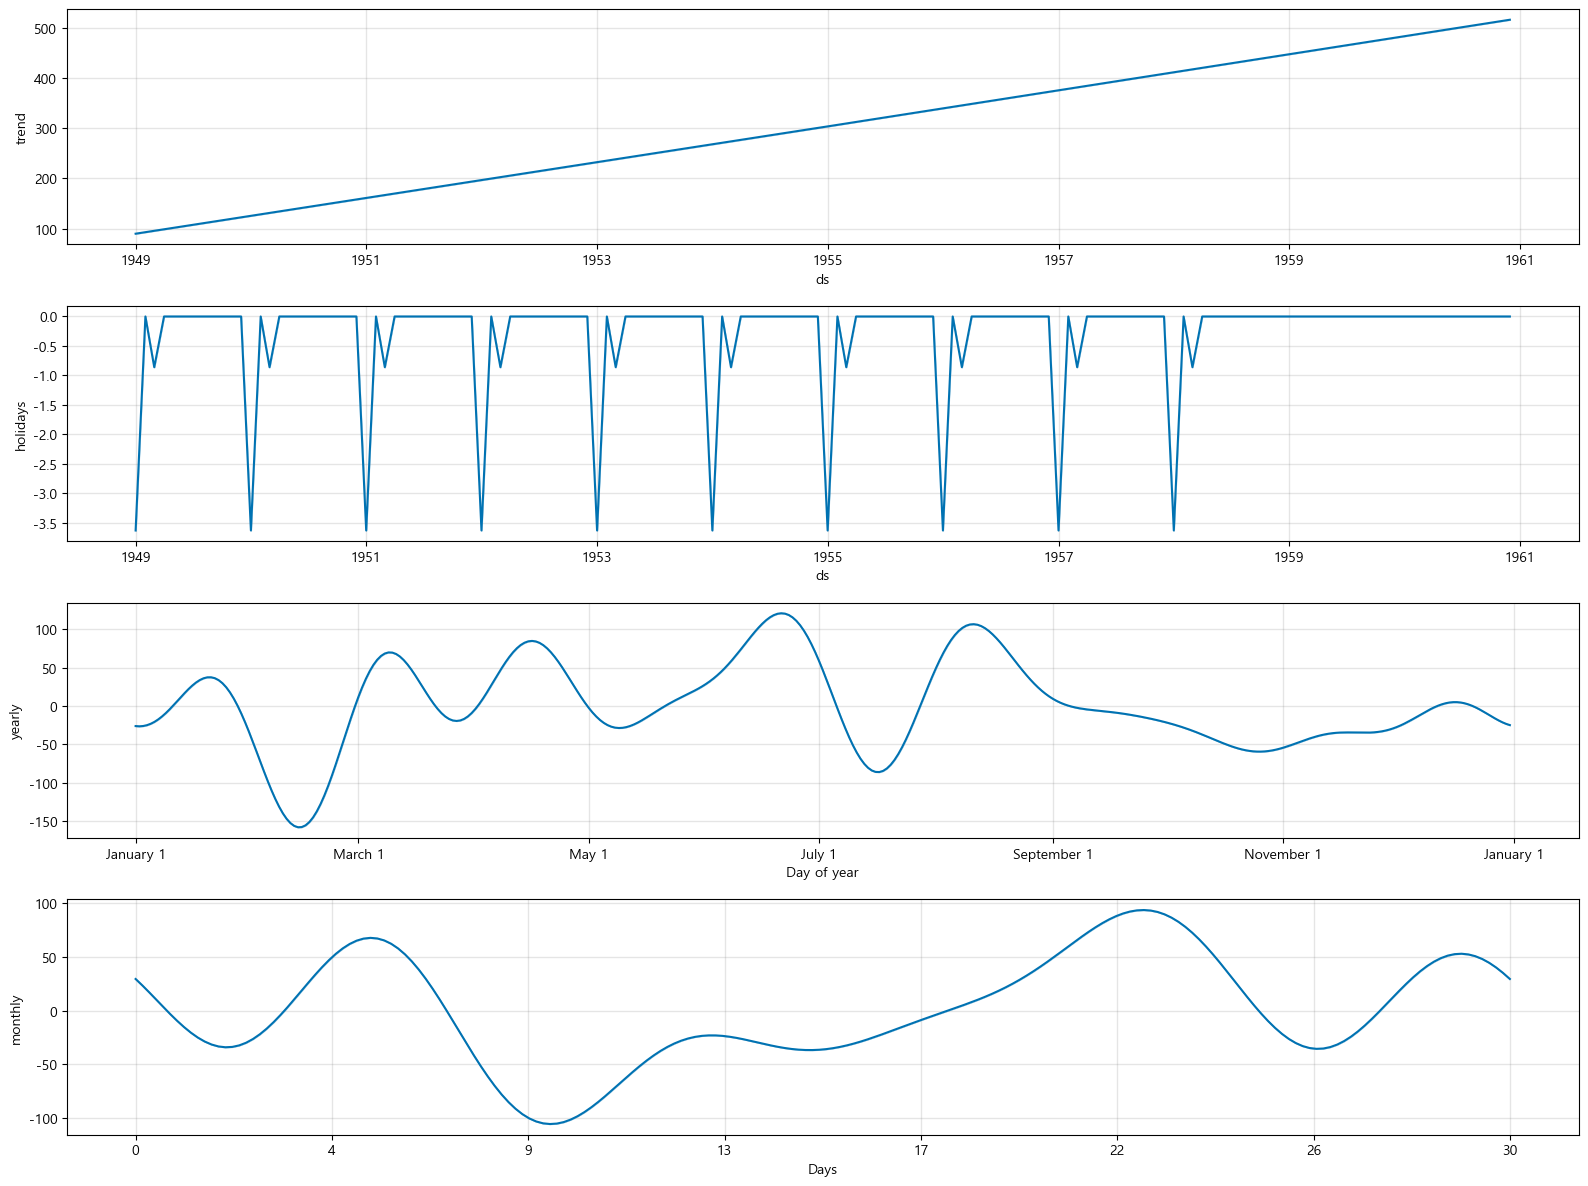

In [18]:
m = Prophet()

# 공휴일 데이터 추가
m.add_country_holidays(country_name='KR')

m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)

fig = m.plot_components(forecast, figsize=(16, 12))
fig.set_dpi(100)
ax = fig.gca()
plt.show()

In [19]:
m.train_holiday_names

0                                        New Year's Day
1                             Independence Movement Day
2                                     Tree Planting Day
3                                      Constitution Day
4                                        Liberation Day
5                                               Chuseok
6                               National Foundation Day
7                                            Hangul Day
8                                    United Nations Day
9                                         Christmas Day
10                                   Local Election Day
11                            Presidential Election Day
12                       National Assembly Election Day
13                                         Memorial Day
14                    President Syngman Rhee's Birthday
15    Anniversary of the 1st National Assembly Election
16                   Baekbeom Kim Ku's Funeral Ceremony
17           Joint Memorial Service for Fallen S

In [20]:
origin2 = pd.read_excel("./data/covid19_seoul_230531.xlsx")

In [21]:
origin2.head()

,서울시 기준일,서울시 확진자,서울시 추가 확진,서울시 치료중,서울시 퇴원,서울시 추가 퇴원,서울시 사망,서울시 의심환자 전체,서울시 의심환자 검사중,서울시 의심환자 검사결과(음성),...,전국 의심환자 전체,전국 의심환자 검사중,전국 의심환자 검사결과(음성),자가격리자 해외입국자 감시중,자가격리자 해외입국자 감시해제,자가격리자 접촉자 감시중,자가격리자 접촉자 감시해제,확인중 확진자,서울시 당일사망자,전국 당일 사망자
0,2023-05-31,6204277,5987.0,0,NaN,NaN,6492,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.0,17.0
1,2023-05-30,6198290,3326.0,0,NaN,NaN,6486,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,7.0
2,2023-05-29,6194964,1393.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0
3,2023-05-28,6194964,1393.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0
4,2023-05-27,6191196,4078.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.0


In [22]:
df2 = origin2[['서울시 기준일', '서울시 추가 확진']]
df2.fillna(0, inplace = True)

In [23]:
df2.head()

,서울시 기준일,서울시 추가 확진
0,2023-05-31,5987.0
1,2023-05-30,3326.0
2,2023-05-29,1393.0
3,2023-05-28,1393.0
4,2023-05-27,4078.0


In [24]:
df2['서울시 기준일'] = pd.to_datetime(df2['서울시 기준일'].str.strip(), format = "%Y-%m-%d")

In [25]:
df2_2 = df2.rename(columns = {'서울시 기준일' : 'ds', '서울시 추가 확진' : 'y'})
df2_2.sort_values('ds', inplace = True)
df2_2.reset_index(drop = True, inplace = True)

In [26]:
df2_3 = df2_2.set_index("ds")

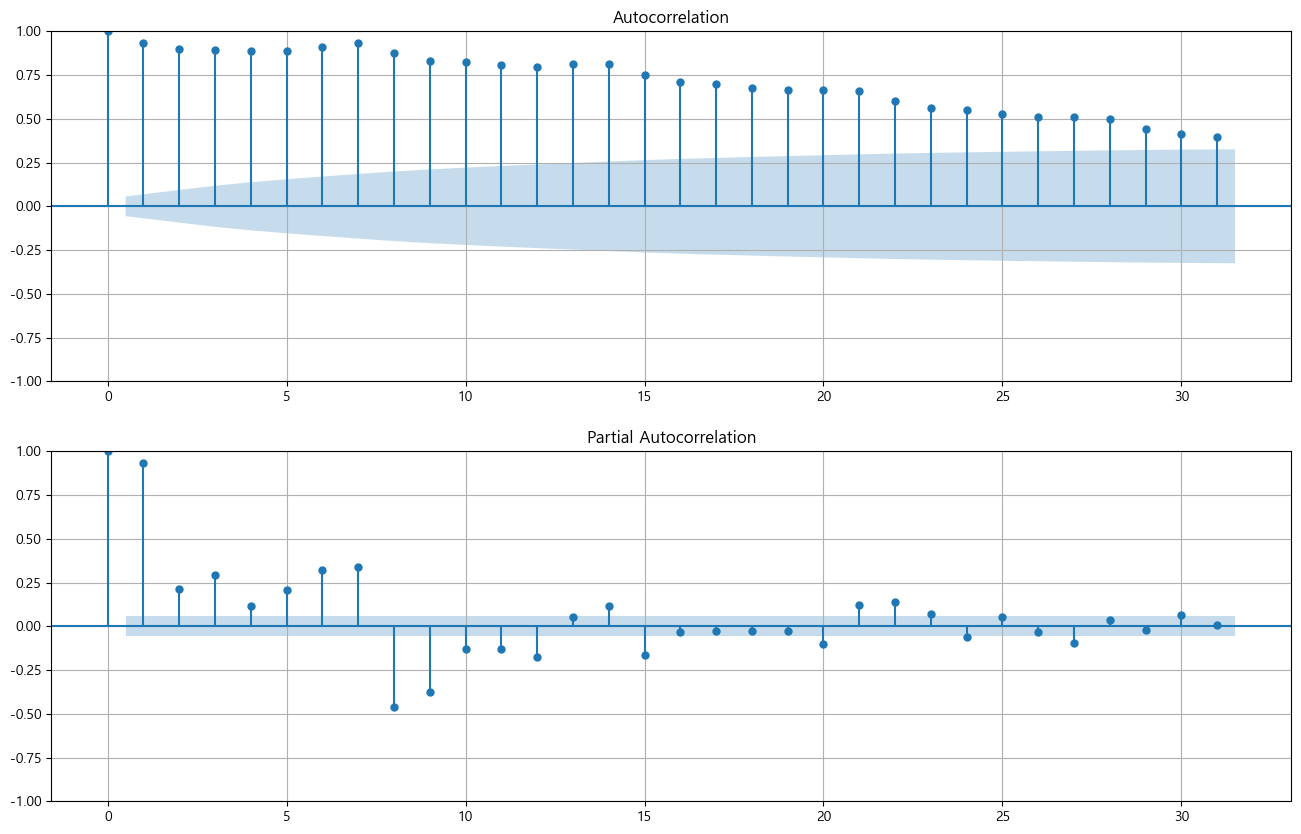

In [27]:
my_acf_pacf_plot(df2_3['y'].dropna(), figsize = (16, 5))

In [28]:
df2_3['y']

ds
2020-02-05       0.0
2020-02-06       0.0
2020-02-07       0.0
2020-02-08       0.0
2020-02-09       0.0
               ...  
2023-05-27    4078.0
2023-05-28    1393.0
2023-05-29    1393.0
2023-05-30    3326.0
2023-05-31    5987.0
Name: y, Length: 1212, dtype: float64

In [29]:
df2_3.index = pd.DatetimeIndex(df2_3.index)

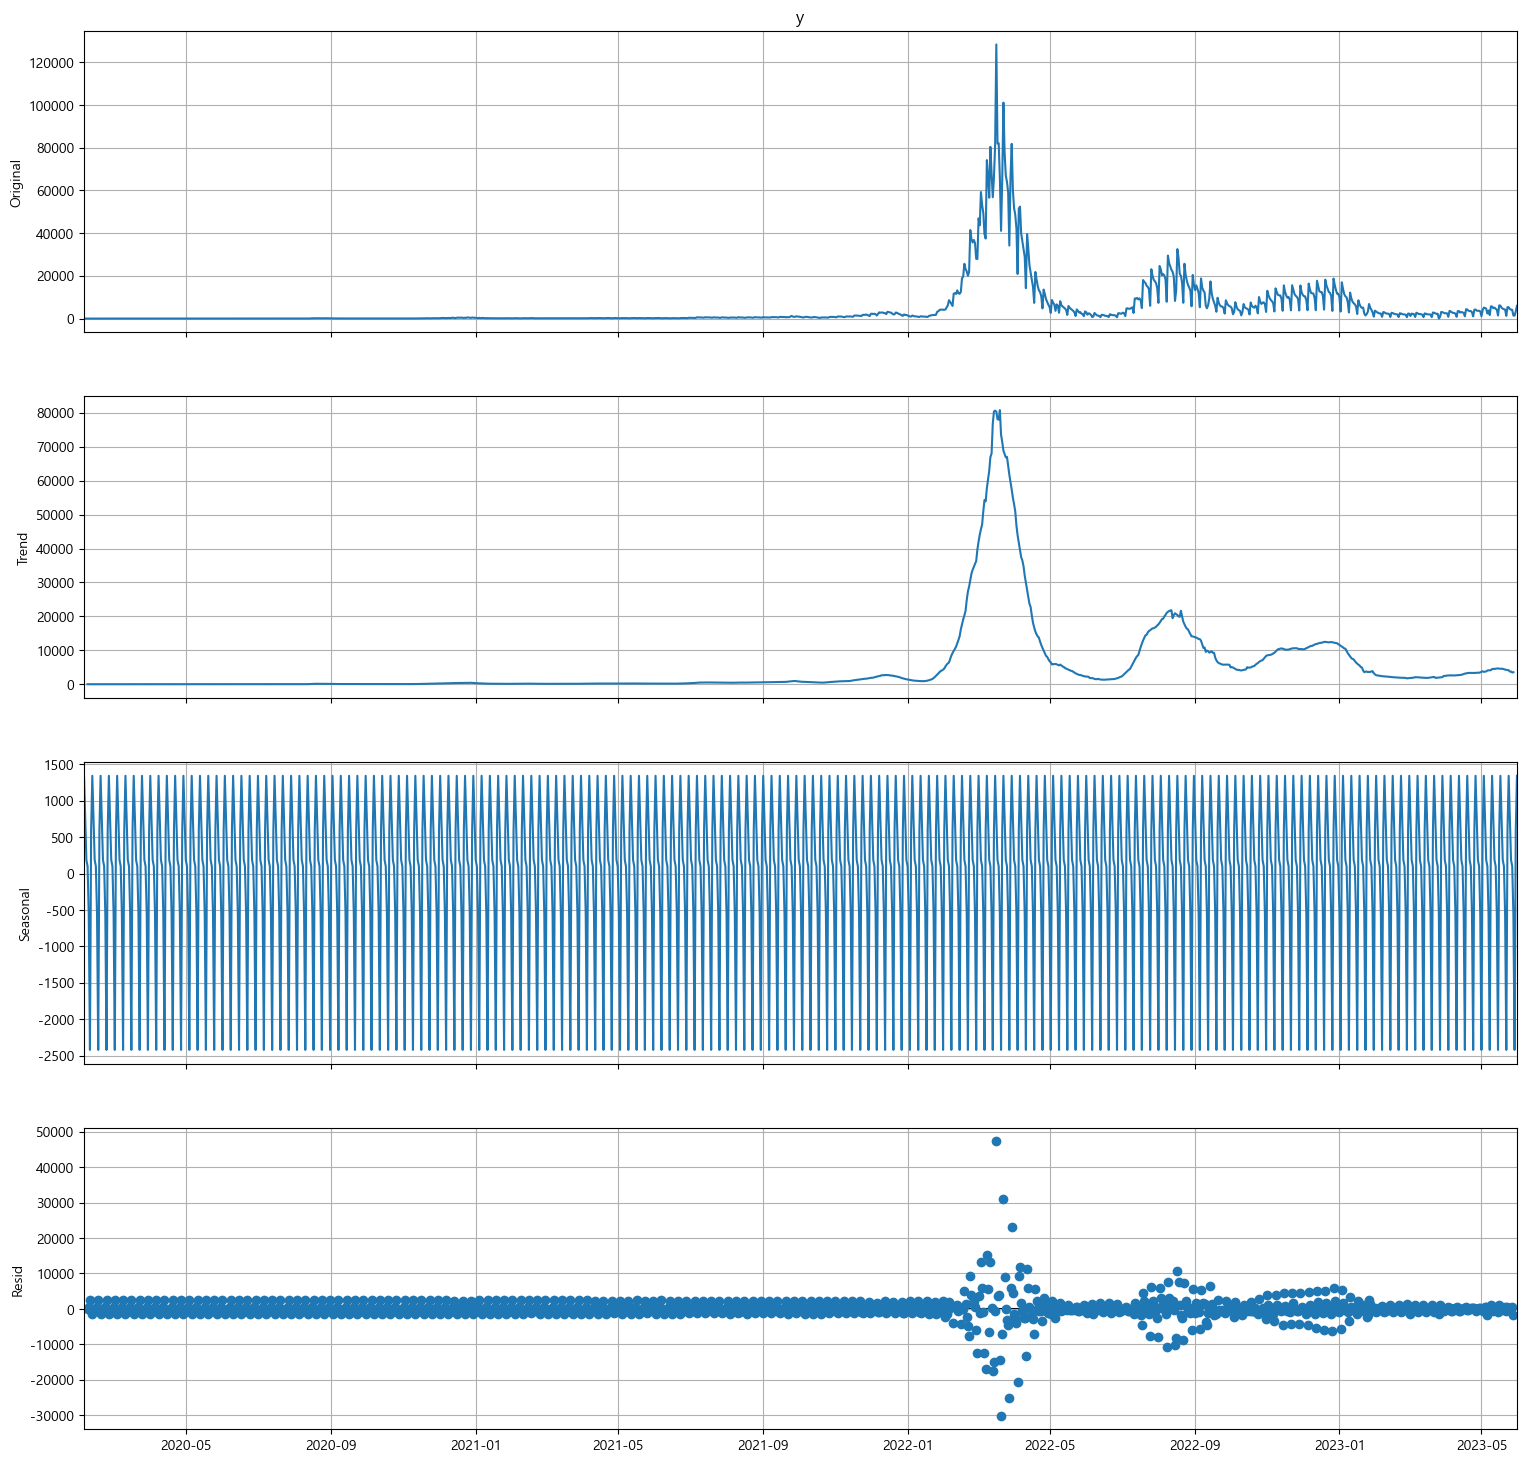

,original,trend,seasonal,resid
ds,,,,
2020-02-05,0.0,NaN,1343.186784,NaN
2020-02-06,0.0,NaN,763.326319,NaN
2020-02-07,0.0,NaN,186.890273,NaN
2020-02-08,0.0,0.000000,100.836008,-100.836008
2020-02-09,0.0,0.000000,-566.656973,566.656973
...,...,...,...,...
2023-05-27,4078.0,3450.571429,100.836008,526.592564
2023-05-28,1393.0,3547.000000,-566.656973,-1587.343027
2023-05-29,1393.0,NaN,-2422.726006,NaN


In [30]:
my_seasonal_decompose(df2_3['y'], figsize = (16, 4))

In [31]:
train, test = my_timeseries_split(df2_2)
train.shape, test.shape

((969, 2), (243, 2))

In [32]:
params = {
    #'growth': ['linear', 'logistic'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality': [True, False],
    'daily_seasonality':  [True, False],
    'yearly_seasonality': [True, False],
}

params

{'changepoint_prior_scale': [0.01, 0.1, 1.0],
 'seasonality_prior_scale': [0.01, 0.1, 1.0],
 'seasonality_mode': ['additive', 'multiplicative'],
 'weekly_seasonality': [True, False],
 'daily_seasonality': [True, False],
 'yearly_seasonality': [True, False]}

In [33]:
from sklearn.model_selection import ParameterGrid

In [44]:
%%time

import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

tmp = ParameterGrid(params)

best_rmse = None
best_model = None
best_params = None

for i in tmp:
    tmp_m = Prophet(**i)
    tmp_m.fit(train)
    tmp_rmse = np.sqrt(mean_squared_error(test['y'], tmp_m.predict(test).sort_values('ds')['yhat']))
    print(f"RMSE : {tmp_rmse}")
    if not best_rmse:
        best_rmse = tmp_rmse
        best_model = tmp_m
        best_params = i
    if tmp_rmse < best_rmse:
        best_rmse = tmp_rmse
        best_model = tmp_m
        best_params = i

RMSE : 20109.977226172785
RMSE : 15498.102752418652
RMSE : 20168.12163804144
RMSE : 15380.705700011351
RMSE : 20293.04919652785
RMSE : 15424.888412186025
RMSE : 20854.967831169266
RMSE : 15326.450665022352
RMSE : 20725.61337169166
RMSE : 15282.059894352184
RMSE : 20875.430014353606
RMSE : 15598.21671867697
RMSE : 16767.223101683452
RMSE : 15447.63418884731
RMSE : 16735.969527966525
RMSE : 15520.63813371722
RMSE : 64137.11659595191
RMSE : 16025.760766243442
RMSE : 60298.55513305942
RMSE : 15462.996005661713
RMSE : 66785.58878308383
RMSE : 17125.324024372916
RMSE : 65525.40917074378
RMSE : 15454.218351008536
RMSE : 20331.014654557366
RMSE : 15461.125361407097
RMSE : 20317.007705775202
RMSE : 15296.939507311334
RMSE : 20631.542577528005
RMSE : 15572.097484719614
RMSE : 20807.61362746967
RMSE : 15296.939507311334
RMSE : 20818.10283870851
RMSE : 15220.05117813281
RMSE : 20852.163025444777
RMSE : 15296.939507311334
RMSE : 16668.506122571907
RMSE : 15420.965307521807
RMSE : 16551.788376726712

In [35]:
best_model

In [45]:
best_rmse

6252.0719782814995

In [37]:
best_params

{'changepoint_prior_scale': 1.0,
 'daily_seasonality': True,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 1.0,
 'weekly_seasonality': True,
 'yearly_seasonality': True}

In [38]:
%%time

import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

def tmp_func(test, i):
    tmp_m = Prophet(**i)
    tmp_m.fit(test)
    tmp_rmse = np.sqrt(mean_squared_error(test['y'], tmp_m.predict(test).sort_values('ds')['yhat']))
    return tmp_m, tmp_rmse, i

result = []
processes = []

tmp = ParameterGrid(params)

with futures.ThreadPoolExecutor() as executor:
    for p in tmp:
        processes.append(executor.submit(tmp_func, train, p))

    for p in futures.as_completed(processes):
        m, score, i = p.result()
        result.append({
            "model" : m,
            "score" : score,
            "params" : i
        })

CPU times: total: 3.19 s
Wall time: 20.4 s


In [39]:
result

[{'model': <prophet.forecaster.Prophet at 0x1ea19d4f750>,
  'score': 11876.72911040742,
  'params': {'changepoint_prior_scale': 0.01,
   'daily_seasonality': True,
   'seasonality_mode': 'multiplicative',
   'seasonality_prior_scale': 0.01,
   'weekly_seasonality': False,
   'yearly_seasonality': False}},
 {'model': <prophet.forecaster.Prophet at 0x1ea19d47890>,
  'score': 11878.103716036287,
  'params': {'changepoint_prior_scale': 0.01,
   'daily_seasonality': True,
   'seasonality_mode': 'multiplicative',
   'seasonality_prior_scale': 0.1,
   'weekly_seasonality': False,
   'yearly_seasonality': False}},
 {'model': <prophet.forecaster.Prophet at 0x1ea19db0dd0>,
  'score': 11874.672003932164,
  'params': {'changepoint_prior_scale': 0.01,
   'daily_seasonality': True,
   'seasonality_mode': 'additive',
   'seasonality_prior_scale': 1.0,
   'weekly_seasonality': False,
   'yearly_seasonality': False}},
 {'model': <prophet.forecaster.Prophet at 0x1ea1b3c11d0>,
  'score': 11872.8531594829

In [40]:
pd.DataFrame(result).sort_values("score")

,model,score,params
116,<prophet.forecaster.Prophet object at 0x000001...,2835.387045,"{'changepoint_prior_scale': 1.0, 'daily_season..."
134,<prophet.forecaster.Prophet object at 0x000001...,2838.285321,"{'changepoint_prior_scale': 1.0, 'daily_season..."
140,<prophet.forecaster.Prophet object at 0x000001...,2841.438568,"{'changepoint_prior_scale': 1.0, 'daily_season..."
119,<prophet.forecaster.Prophet object at 0x000001...,2843.899818,"{'changepoint_prior_scale': 1.0, 'daily_season..."
82,<prophet.forecaster.Prophet object at 0x000001...,2853.771408,"{'changepoint_prior_scale': 0.1, 'daily_season..."
...,...,...,...
42,<prophet.forecaster.Prophet object at 0x000001...,11882.106284,"{'changepoint_prior_scale': 0.01, 'daily_seaso..."
29,<prophet.forecaster.Prophet object at 0x000001...,11882.106284,"{'changepoint_prior_scale': 0.01, 'daily_seaso..."
40,<prophet.forecaster.Prophet object at 0x000001...,11882.106284,"{'changepoint_prior_scale': 0.01, 'daily_seaso..."
23,<prophet.forecaster.Prophet object at 0x000001...,11882.106284,"{'changepoint_prior_scale': 0.01, 'daily_seaso..."


In [41]:
tmp2 = yjk_prophet_gridsearch(train, test, params)

In [42]:
tmp2

,model,params,score
0,<prophet.forecaster.Prophet object at 0x000001...,"{'changepoint_prior_scale': 1.0, 'daily_season...",6252.071978
1,<prophet.forecaster.Prophet object at 0x000001...,"{'changepoint_prior_scale': 0.1, 'daily_season...",7625.939420
2,<prophet.forecaster.Prophet object at 0x000001...,"{'changepoint_prior_scale': 0.1, 'daily_season...",11430.791239
3,<prophet.forecaster.Prophet object at 0x000001...,"{'changepoint_prior_scale': 0.1, 'daily_season...",11477.658426
4,<prophet.forecaster.Prophet object at 0x000001...,"{'changepoint_prior_scale': 0.1, 'daily_season...",11714.180107
...,...,...,...
139,<prophet.forecaster.Prophet object at 0x000001...,"{'changepoint_prior_scale': 1.0, 'daily_season...",102849.879390
140,<prophet.forecaster.Prophet object at 0x000001...,"{'changepoint_prior_scale': 1.0, 'daily_season...",107003.409521
141,<prophet.forecaster.Prophet object at 0x000001...,"{'changepoint_prior_scale': 1.0, 'daily_season...",108483.639111
142,<prophet.forecaster.Prophet object at 0x000001...,"{'changepoint_prior_scale': 1.0, 'daily_season...",109756.186936
